# Семинар 3: Normalizing Flows
## Вступление

В предыдущих семинарах мы рассмотрели модели на основе генеративно-состязательных сетей (GAN) и диффузионных процессов как примеры генеративных моделей.
Однако ни одна из них не обучает в явном виде функцию плотности вероятности $p(x)$ реальных входных данных, а только предоставляют нам механизм для генерации новых данных.
Генеративная модель, которую мы рассмотрим здесь, под названием Normalizing Flows, фактически моделирует истинное распределение данных
$p(x)$ и предоставляет нам точную оценку правдоподобия.


### План семинара:
1. Готовим базовые классы и основные функции
2. Обучаем простейшие нормпотоки на двумерных данных
3. Обучаем RealNVP на двумерных данных
4. Обучаем RealNVP на MNIST
5. Bonus: NF prior для VAE



In [ ]:
import numpy as np
import sklearn.datasets
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
from IPython.display import clear_output
from matplotlib import patches, pyplot as plt
from matplotlib.colors import to_rgb
from torch import nn, optim
from torchvision.datasets import MNIST

%matplotlib inline

device = "cuda:0"
torch.cuda.set_device(0)

## Recap

<center width="100%"><img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png" width="600px"></center>


Normalizing Flows (нормпотоки) — генеративные модели, построенные на объединении биективных (обратимых) функций. В процессе обучения мы берем объект из данных и прогоняем его через нормпоток по направлению к априорному распределению, применяя серию биективных функций $f_i$. В процессе генерации всё наоборот: семплируется объект из априорного распределения (как и в случае с VAE и GAN, обычно, это стандартное нормальное распределение) и друг за другом прогоняется через обратные функции $g_i$. На выходе из нормпотока мы ожидаем получить объект из распределения на данных.

Основное отличие от VAE заключается в том, что потоки используют *инвертируемые* функции $f$
для отображения входных данных $x$ в скрытое представление $z$.
Для этого $z$ должно иметь ту же форму, что и $x$.
Это отличается от VAE, где $z$ обычно имеет гораздо меньшую размерность, чем исходные входные данные.
Однако инвертируемое отображение также означает, что для каждой точки данных $x$ у нас есть соответствующее латентное представление
$z$, что позволяет нам выполнять реконструкцию без потерь ($z$ в $x$).
В приведенной выше визуализации это означает, что $x=x'$ для потоков, независимо от того, какую инвертируемую функцию $f$ и входные данные $x$ мы выбираем.

NF моделируют плотность вероятности, используя правило замены переменных.
Если задана плотность $p_z(z)$ (например, гауссовская) и обратимая функция $f$,
мы можем определить $p_x(x)$ следующим образом:
$$
\begin{split}
    \int p_x(x) dx & = \int p_z(z) dz = 1 \hspace{1cm}\text{(by definition of a probability distribution)}\\
    \Leftrightarrow p_x(x) & = p_z(z) \left|\frac{dz}{dx}\right| = p_z(f(x)) \left|\frac{df(x)}{dx}\right|
\end{split}
$$


Обучение нормпотоков происходит путем максимизации логарифма правдоподобия объектов (maximum likelihood principle), который вычисляется через **change of variables formula**:

$$\log p(x) = \log p_{prior}(x_{k}) + \sum_{i} \log \Big| \det \Big(\frac{\delta f(x_i)}{x_i} \Big) \Big| $$


Хотя мы теперь знаем, как нормализующий поток обучается, интуитивно может быть непонятно, что именно он.
Для этого нам следует взглянуть на поток с обратной точки зрения, начав с плотности вероятности $p_z(z)$.
Если мы применим к ней обратимую функцию, то эффективно "преобразуем" ее плотность вероятности.
Например, если $f^{-1}(z)=z+1$, мы сдвигаем плотность на единицу, оставаясь при этом правильным распределением вероятностей,
и инвертируемым.
Мы можем применять и более сложные преобразования, например масштабирование: $f^{-1}(z)=2z+4$, но здесь вы можете заметить разницу.
При масштабировании также изменяется объем плотности вероятности, как, например, для равномерных распределений:


In [ ]:
x = np.random.uniform(0, 1, 10000)
f = lambda x: 2 * x + 3
y = f(x)

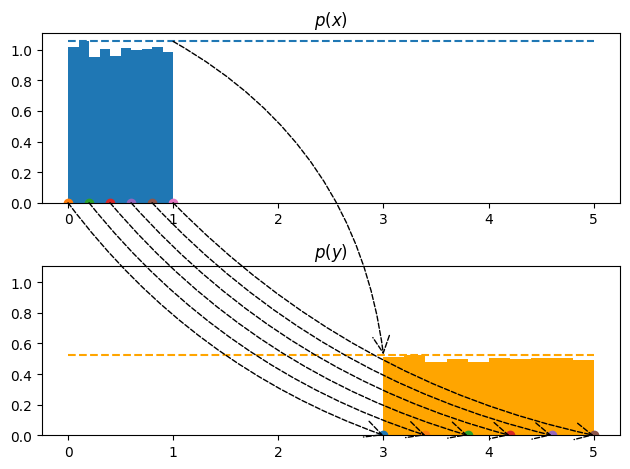

In [ ]:
fig = plt.figure()

# p(x)
ax1 = fig.add_subplot(211)
hx, bins_x, _ = plt.hist(x, density = True);
plt.hlines(max(hx), 0, 5, linestyle = '--')
ax1.title.set_text('$p(x)$')

# p(y)
ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
hy, bins_y, _ =plt.hist(y, density = True, color = 'orange');
plt.hlines(max(hy), 0, 5, linestyle = '--', color = 'orange')
ax2.title.set_text('$p(y)$')

# max x -> max y
fig.tight_layout()
arrow = patches.ConnectionPatch(
      [1, max(hx)],
      [3, max(hy)],
      coordsA=ax1.transData,
      coordsB=ax2.transData,
      color="black",
      arrowstyle="->",
      connectionstyle="arc3,rad=-.25",
      mutation_scale=30,
      linewidth=1,
      linestyle = '--'
  )
fig.patches.append(arrow)

# Transitions
for i in range(0, len(bins_x), 2):
  xyA = [bins_x[i], 0]
  ax1.plot(*xyA, "o")
  xyB = [bins_y[i], 0]
  ax2.plot(*xyB, "o")
  arrow = patches.ConnectionPatch(
      xyA,
      xyB,
      coordsA=ax1.transData,
      coordsB=ax2.transData,
      color="black",
      arrowstyle="->",
      connectionstyle="arc3,rad=.15",
      mutation_scale=30,
      linewidth=1,
      linestyle = '--'
  )
  fig.patches.append(arrow)

plt.show()

После масштабирования высота $p(y)$ должна быть меньше, чем $p(x)$.
Это изменение объема представляет собой $\left|\frac{df(x)}{dx}\right|$ в нашем уравнении выше, и гарантирует, что даже после масштабирования у нас все еще есть правильное распределение вероятностей.
Мы можем продолжать усложнять нашу функцию $f$.
Однако чем сложнее становится $f$, тем труднее будет найти ее обратную $f^{-1}$, и вычислить логарифм якобиана $\log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|$.
Более простой трюк - настакать несколько функций $f_{1,...,K}$ друг за другом, так как все вместе они все равно представляют собой одну обратимую функцию.
Используя несколько обучаемых функций, нормализующий поток пытается преобразовать $p_z(z)$ в более сложное распределение, которое в итоге должно стать $p_x(x)$:

<center width="100%"><img src="https://raw.githubusercontent.com/janosh/awesome-normalizing-flows/75108d9d3a41bd5af94d8cd252358979f800ec47/assets/normalizing-flow.svg" width="700px"></center>

А теперь попробуем обучить NF.

## 1. Готовим базовые классы и основные функции
Абстрактные классы для блока нормпотока `InvertibleLayer` и для всего нормпотока `NormalizingFlow` можно определить следующим образом.

У блока `InvertibleLayer` должны быть определены две функции:

* `def f(self, x)`, которая делает прямое преобразование и возвращает два значения: $f(x)$ и $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$
* `def g(self, x)`, которая делает обратное преобразование и возвращает одно значение: $f^{-1}(x)$

Чтобы проверить, что ваш код написан правильно, используйте функции `check_inverse` и `check_log_det` для проверки обратимости слоя и для проверки правильности подсчета $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$

In [ ]:
class InvertibleLayer(nn.Module):
    def __init__(self, var_size):
        super().__init__()
        self.var_size = var_size

    def f(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        pass

    def g(self, x: torch.Tensor) -> torch.Tensor:
        """
        Inverse pass
        """
        pass

    def check_inverse(self) -> None:
        """
        Perform check of invertibility
        """
        x = torch.randn(10, self.var_size)
        assert torch.norm(x - self.g(self.f(x)[0])).item() < 0.001

    def check_log_det(self) -> None:
        """
        Perform check of log determinant
        """
        x = torch.randn(1, self.var_size).requires_grad_()
        _, log_det = self.f(x)

        jac = torch.autograd.functional.jacobian(lambda x: self.f(x)[0], x)
        assert torch.abs(log_det - torch.log(torch.det(jac[0, :, 0, :]))).item() < 0.001

Класс `NormalizingFlow` инициализируется списком обратимых слоев и нормальным прайором. А так же реализует функции `log_prob` для подсчета логарифма правдоподобия объектов и `sample` для семплирования объектов.

In [ ]:
class NormalizingFlow(nn.Module):
    def __init__(self, layers, prior):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + change
            else:
                log_likelihood = change
        log_likelihood = log_likelihood + self.prior.log_prob(x)

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples,))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

Как и говорилось ранее, обучение нормпотока происходит путем максимизации правдоподобия объектов.

Важный момент: если вы работаете с дискретными данными (например с MNIST, у которого пиксели либо 0, либо 1), не забывайте делать *деквантизацию* — прибавление мелкого шума к объекту. Это необходимо для предотвращения численных неустойчивостей при обучении.

In [ ]:
def train_nf(tr_dataloader, nf, opt, num_epochs, verbose_num_iters=100, data_type="2d"):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for batch in tr_dataloader:
            x, _ = batch
            x = x.to(device)

            if data_type == "mnist":
                x = x.view(x.shape[0], -1)
                # деквантизация
                x = x + 0.05 * torch.randn_like(x)

            # делаем шаг обучения
            opt.zero_grad()
            loss = -nf.log_prob(x)
            loss.backward()
            opt.step()
            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Normalizing flow loss")
                plt.plot([p[0] for p in loss_trace], [p[1] for p in loss_trace])

                nf.eval()
                if data_type == "2d":
                    plt.subplot(1, 2, 2)
                    with torch.no_grad():
                        sampled_2d = nf.sample(1024)
                    plt.xlim(-2, 2)
                    plt.ylim(-2, 2)
                    plt.scatter(
                        sampled_2d[:, 0].cpu().detach().numpy(),
                        sampled_2d[:, 1].cpu().detach().numpy(),
                        s=1,
                    )
                elif data_type == "mnist":
                    with torch.no_grad():
                        sampled_mnist = torch.clamp(nf.sample(100), min=-1.0, max=1.0)

                    for i in range(100):
                        plt.subplot(10, 20, 20 * (i // 10) + 11 + (i % 10))
                        plt.axis("off")
                        plt.imshow(
                            sampled_mnist[i].view(16, 16).detach().cpu().numpy(),
                            cmap="gray",
                        )

                plt.show()
                nf.train()

    nf.eval()

## 2. Обучаем простейшие нормпотоки на двумерных данных

Для начала, чтобы познакомиться с нормпотоками и написать простой норм поток, давайте попробуем смоделировать вот такое многомодальное распределение.

In [ ]:
class Dataset2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

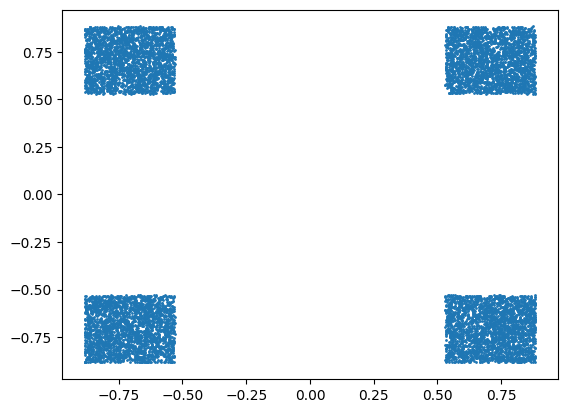

In [ ]:
total_size = 10000

scale = 1.0
centers = [(x, y) for x in [-1, 1] for y in [-1, 1]]
centers = [(scale * x, scale * y) for x, y in centers]

dataset = []

rng = np.random.RandomState()

for i in range(total_size):
    point = (rng.rand(2) - 0.5) * 0.5
    idx = rng.randint(len(centers))
    center = centers[idx]
    point[0] += center[0]
    point[1] += center[1]
    dataset.append(point)
x = np.array(dataset, dtype="float32")
x /= 1.414

plt.scatter(x[:, 0], x[:, 1], s=1);

In [ ]:
trainset = Dataset2d(x, torch.zeros(x.shape[0]))
trainloader_2d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Для моделирования предлагается использовать следующие преобразования:

1. ActNorm - произоводим обратимый сдвиг на $b$ и растяжение пространства на $w$.

$$f_{w, b}(x) = w \odot x + b ;\\
f^{-1}_{w, b}(x) = (x - b) \oslash w \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum_i \log |w_i| $$

2. Монотонная нелинейность, например такая

$$f(x) = \begin{cases}
x \text{ if } |x| > 1; \\
x^3 \text{if} |x| \le 1;
\end{cases} \\
f^{-1}(x) = \begin{cases}
x \text{ if } |x| > 1; \\
x^{1/3} \text{if} |x| \le  1;
\end{cases} \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum_i \mathbb{I}[|x| \le  1] \log (3 x^2) $$


In [ ]:
class ActNorm(InvertibleLayer):
    def __init__(self, var_size):
        super().__init__(var_size=var_size)

        # model w as torch.exp(self.log_w)
        self.log_w = nn.Parameter(torch.randn(var_size))
        self.bias = nn.Parameter(torch.zeros(var_size))

        self.initialized = False

    def f(self, x):
        if not self.initialized:
            self.bias.data = -x.mean(dim=0)
            self.log_w.data = -torch.log(x.std(dim=0) + 1e-1)
            self.initialized = True

        new_x = torch.exp(self.log_w[None, :]) * x + self.bias
        log_det = self.log_w.sum()
        return new_x, log_det

    def g(self, x):
        return torch.exp(-self.log_w[None, :]) * (x - self.bias)


class InvNonlin(InvertibleLayer):
    def __init__(self, var_size):
        super().__init__(var_size=var_size)

    def f(self, x):
        mask = (torch.abs(x) < 1).float()
        pow = 3 * mask + 1 * (1 - mask)

        signs = torch.sign(x)
        new_x = signs * ((x * signs) ** pow)

        log_det = torch.log((3 * (x**2)) * mask + (1 - mask)).sum(dim=-1)

        return new_x, log_det

    def g(self, x):
        mask = (torch.abs(x) < 1).float()
        pow = (1.0 / 3) * mask + 1 * (1 - mask)

        signs = torch.sign(x)
        new_x = signs * ((x * signs) ** pow)

        return new_x

Проверим, что мы правильно реализовали наш код.

In [ ]:
layer = ActNorm(var_size=2)
layer.check_inverse()
layer.check_log_det()

layer = InvNonlin(var_size=2)
layer.check_inverse()
layer.check_log_det()

Накидаем несколько обратимых слоев и попробуем обучить.

In [ ]:
prior = torch.distributions.MultivariateNormal(
    torch.zeros(2).cuda(), torch.eye(2).cuda()
)

layers = []
for i in range(9):
    if i % 2 == 0:
        layers.append(ActNorm(2))
    else:
        layers.append(InvNonlin(2))

nf = NormalizingFlow(layers=layers, prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

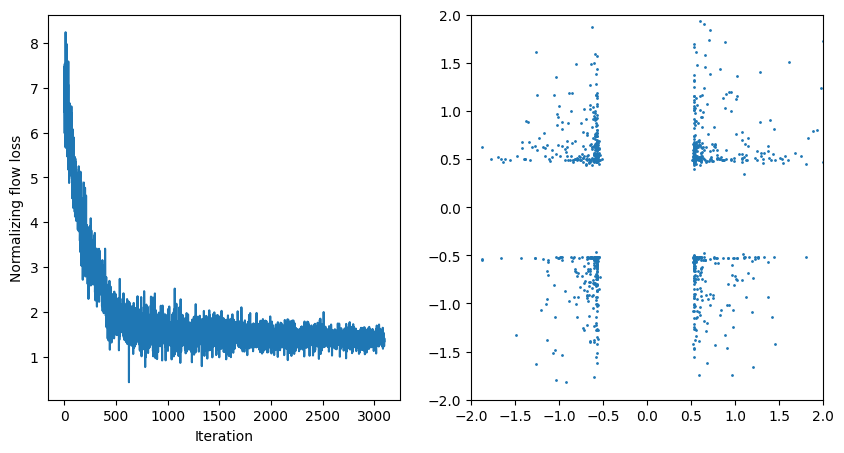

In [ ]:
train_nf(trainloader_2d, nf, opt, num_epochs=20, verbose_num_iters=100, data_type="2d")

Написанные нами обратимые преобразования крайне просты и содержат мало обучаемых параметров, однако даже их хватает для разделения нормального распределения на 4 моды. На практике же чаще используют RealNVP: обратимые слои, параметризуемые нейронками, которые во много раз более гибкие, чем те, что мы реализовали сейчас.

## 3. Обучаем RealNVP на двумерных данных

RealNVP — обратимое преобразование, параметризуемое нейронными сетями $t_{\theta}, s_{\omega}$. Для его работы описание объекта $x$ случайным образом разделяют на две группы $x_a, x_b$ и преобразуют только одну группу $x_b$, опираясь на выходы нейронных сетей для группы $x_a$.

$$
\begin{cases}
f_{\theta, \omega}(x_a) = x_a; \\
f_{\theta, \omega}(x_b) = x_b \odot \exp(s_{\omega}(x_a)) + t_{\theta}(x_a)
\end{cases} \\
\begin{cases}
f^{-1}_{\theta, \omega}(x_a) = x_a; \\
f^{-1}_{\theta, \omega}(x_b) = (x_b -  t_{\theta}(x_a)) \odot \exp(-s_{\omega}(x_a))
\end{cases} \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum s_{\omega}(x_a)
$$

In [ ]:
class RealNVP(InvertibleLayer):
    def __init__(self, var_size, mask, hidden=16):
        super().__init__(var_size=var_size)

        self.mask = mask

        self.nn_t = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size),
        )
        self.nn_s = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size),
        )

    def f(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(
            self.nn_s(x * self.mask[None, :])
        )  # tanh важен, чтобы ограничить scale снизу и сверху

        new_x = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[
            None, :
        ]
        log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
        return new_x, log_det

    def g(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :]))

        new_x = ((x - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + x * self.mask[
            None, :
        ]
        return new_x

In [ ]:
# не забываем проверить правильность написанного кода
layer = RealNVP(var_size=2, mask=torch.tensor([0, 1]))
layer.check_inverse()
layer.check_log_det()

In [ ]:
prior = torch.distributions.MultivariateNormal(
    torch.zeros(2).cuda(), torch.eye(2).cuda()
)

layers = []
for i in range(16):
    layers.append(ActNorm(var_size=2))
    layers.append(RealNVP(var_size=2, mask=((torch.arange(2) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers, prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

Обучим на том же датасете из четырех мод.

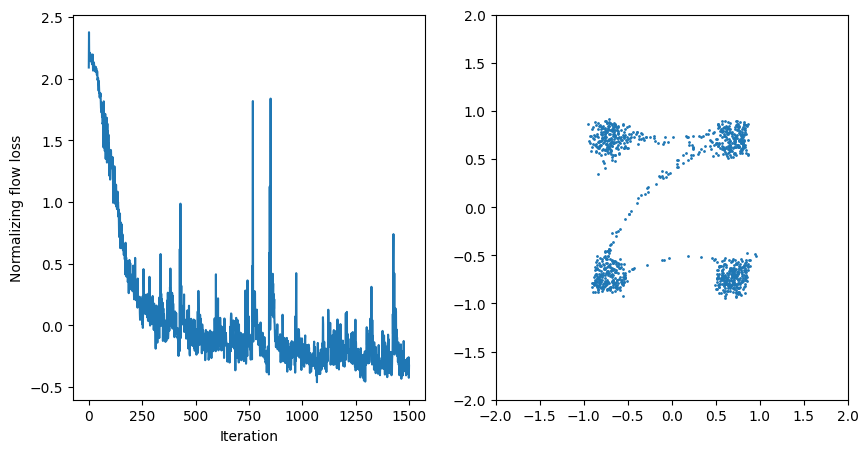

In [ ]:
train_nf(trainloader_2d, nf, opt, num_epochs=10, verbose_num_iters=100, data_type="2d")

Получилось! Хоть и остались перешейки, соединяющие моды, однако выученное распределение почти в точности совпадает с распределением над данными.

Теперь попробуем датасет потяжелее.

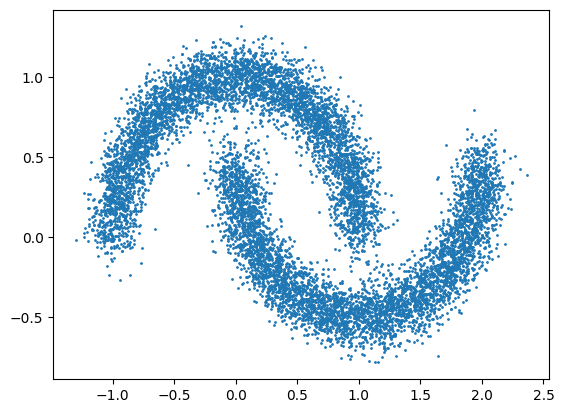

In [ ]:
data = sklearn.datasets.make_moons(n_samples=10000, noise=0.1)[0]
x = data.astype("float32")
plt.scatter(x[:, 0], x[:, 1], s=1);

In [ ]:
trainset = Dataset2d(x, torch.zeros(x.shape[0]))
trainloader_2d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

prior = torch.distributions.MultivariateNormal(
    torch.zeros(2).cuda(), torch.eye(2).cuda()
)

layers = []
for i in range(8):
    layers.append(ActNorm(var_size=2))
    layers.append(RealNVP(var_size=2, mask=((torch.arange(2) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers, prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

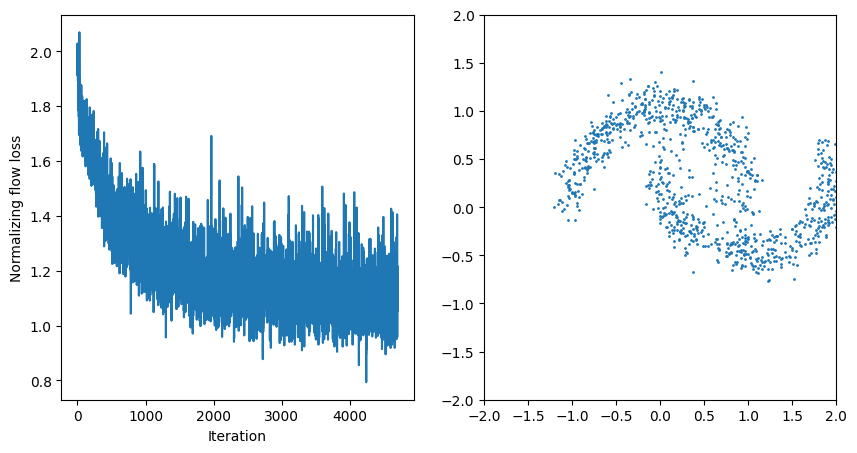

In [ ]:
train_nf(trainloader_2d, nf, opt, num_epochs=30, verbose_num_iters=100, data_type="2d")

**Hint**: Иногда у RealNVP не хватает мощности, чтобы выучить какое-то распределение. Ахиллесова пята RealNVP в том, что он обновляет за раз только половину переменных. В случае с 2d данными это может становиться bottleneck'ом. Для низкоразмерных данных применяют следующий трюк: добавляют к данным несколько фиктивных размерностей, заполненных шумом.

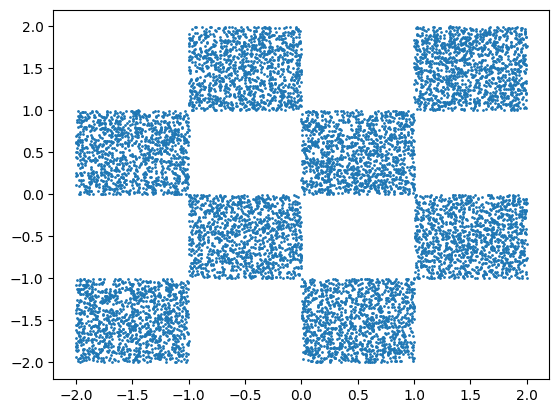

In [ ]:
total_size = 10000
x1 = np.random.rand(total_size) * 4 - 2
x2_ = np.random.rand(total_size) - np.random.randint(0, 2, total_size) * 2
x2 = x2_ + (np.floor(x1) % 2)
data = np.concatenate([x1[:, None], x2[:, None]], 1)
x = np.array(data, dtype="float32")

plt.scatter(x[:, 0], x[:, 1], s=1);

In [ ]:
x_4d = np.concatenate([x, np.random.randn(x.shape[0], 2)], axis=1).astype(np.float32)

trainset = Dataset2d(x_4d, torch.zeros(x_4d.shape[0]))
trainloader_4d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

prior = torch.distributions.MultivariateNormal(
    torch.zeros(4).cuda(), torch.eye(4).cuda()
)

layers = []
for i in range(32):
    layers.append(ActNorm(var_size=4))
    layers.append(RealNVP(var_size=4, mask=((torch.arange(4) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers, prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

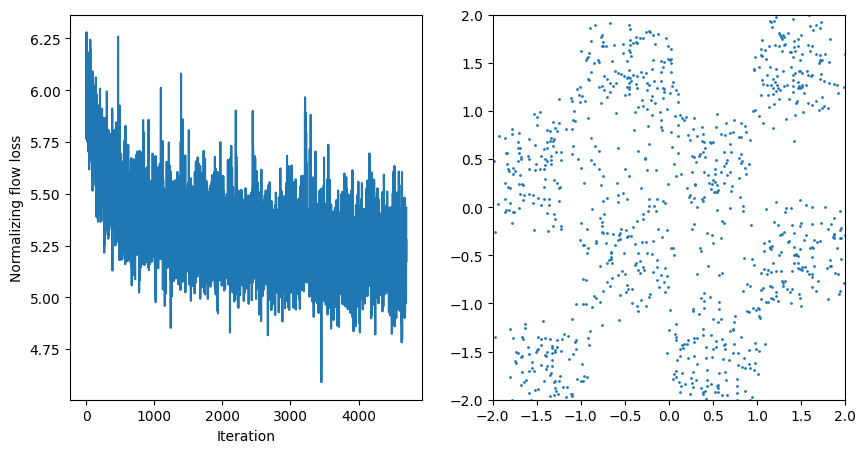

In [ ]:
train_nf(trainloader_4d, nf, opt, num_epochs=30, verbose_num_iters=100, data_type="2d")

## 4. Обучаем RealNVP на MNIST


### Деквантизация

Нормализующие потоки опираются на правило замены переменных, которое естественным образом определяется в непрерывном пространстве.
Применение потоков непосредственно к дискретным данным приводит к нежелательным моделям плотности, в которых произвольно высокие вероятности приписываются нескольким конкретным значениям:

<center><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/09-normalizing-flows/dequantization_issue.svg" width="40%"/></center>

Черные кружки представляют собой дискретные точки, а зеленый объем - плотность, смоделированную нормализующим потоком в непрерывном пространстве.
Поток продолжал бы увеличивать правдоподобие для $x=0,1,2,3$, не имея при этом объема ни для одной другой точки.
Помните, что в непрерывном пространстве у нас есть ограничение на то, что общий объем плотности вероятности должен быть равен 1 ($\int p(x)dx=1$).
В противном случае мы больше не моделируем распределение вероятностей.
Однако дискретные точки $x=0,1,2,3$ представляют собой дельта-пики, не имеющие ширины в непрерывном пространстве.
Именно поэтому поток может поместить бесконо высокое правдоподобие в эти несколько точек, продолжая при этом представлять распределение в непрерывном пространстве.
Тем не менее, полученная плотность ничего не говорит нам о распределении между дискретными точками,
поскольку в дискретном пространстве сумма вероятностей этих четырех точек должна была бы равняться 1, а не бесконечности.

Для предотвращения таких вырожденных решений обычно добавляют небольшое количество шума к каждому дискретному значению, что также называется **деквантизацией**.
Если рассматривать $x$ как целое число (как в случае с изображениями из MNIST), то деквантованное представление $v$ можно сформулировать как $v=x+u$, где $u\in[0,1)^D$.
Таким образом, дискретное значение $1$ моделируется распределением на интервале $[1.0, 2.0)$, значение $2$ - объемом на $[2.0, 3.0)$ и т.д.
Наша задача моделирования $p(x)$ становится следующей:

$$ p(x) = \int p(x+u)du = \int \frac{q(u|x)}{q(u|x)}p(x+u)du = \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$$


In [ ]:
class Dequantization(nn.Module):
    def __init__(self, alpha=1e-5, quants=256):
        """Dequantization.

        Args:
            alpha: small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants: Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants - 1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z - 2 * F.softplus(-z)).sum(dim=[1, 2, 3])
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1 - z)).sum(dim=[1, 2, 3])
            z = torch.log(z) - torch.log(1 - z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

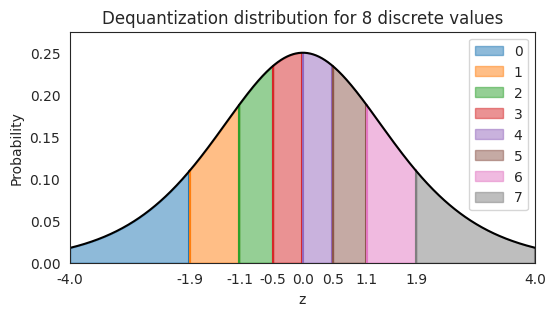

In [ ]:
def visualize_dequantization(quants, prior=None):
    """Function for visualizing the dequantization values of discrete values in continuous space."""
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1)  # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out]  # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    _ = plt.figure(figsize=(6, 3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out == v)
        color = to_rgb("C%i" % v)
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color + (0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]] * 2, [0, prob[indices[0][0]]], color=color)
        plt.plot([inp[indices[0][-1]]] * 2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, ["%.1f" % x for x in x_ticks])
    plt.plot(inp, prob, color=(0.0, 0.0, 0.0))
    # Set final plot properties
    plt.ylim(0, prob.max() * 1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title("Dequantization distribution for %i discrete values" % quants)
    plt.legend()
    plt.show()
    plt.close()


visualize_dequantization(quants=8)

### RealNVP
RealNVP слои настолько мощные, что могут научиться моделировать распределение над реальными данными, например, над картинками.

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(16), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = MNIST(root="./data/", train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=8
)

prior = torch.distributions.MultivariateNormal(
    torch.zeros(16 * 16).cuda(), torch.eye(16 * 16).cuda()
)

layers = []
for i in range(12):
    layers.append(
        RealNVP(var_size=16 * 16, mask=torch.randint(0, 2, (16 * 16,)).cuda())
    )
    layers.append(ActNorm(var_size=16 * 16))

nf = NormalizingFlow(layers=layers, prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=3e-4)

100%|██████████| 9912422/9912422 [00:00<00:00, 111380318.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88034661.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31752237.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20528587.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


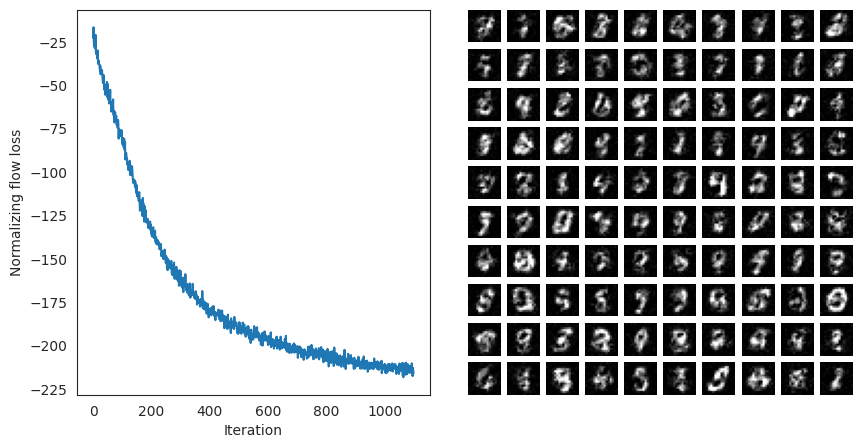

In [ ]:
train_nf(
    trainloader_mnist, nf, opt, num_epochs=10, verbose_num_iters=100, data_type="mnist"
)

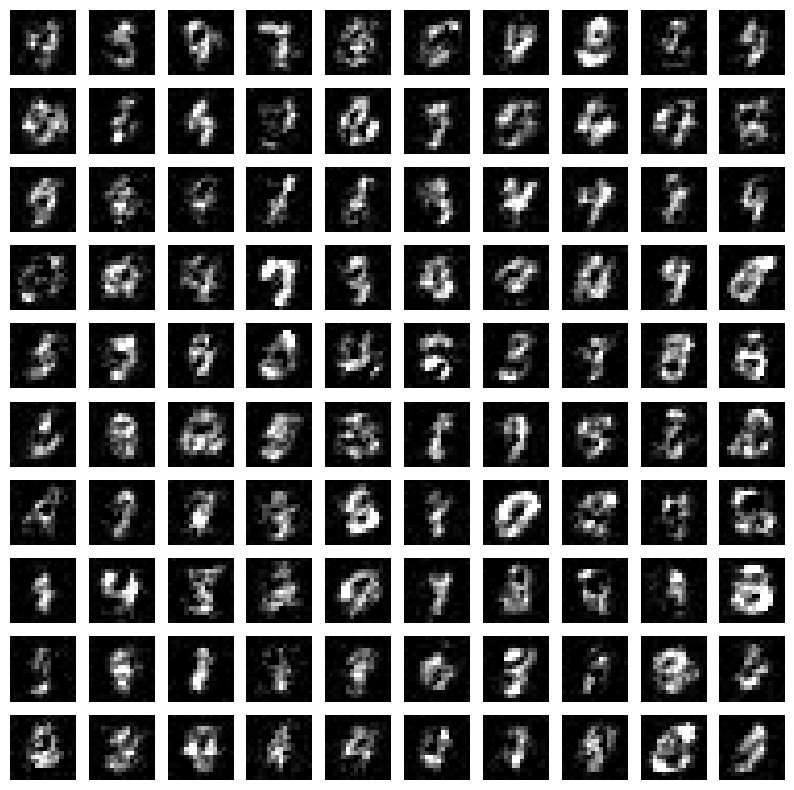

In [ ]:
with torch.no_grad():
    sampled_mnist = torch.clamp(nf.sample(100), min=-1.0, max=1.0)

plt.figure(figsize=(10, 10))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis("off")
    plt.imshow(sampled_mnist[i].view(16, 16).detach().cpu().numpy(), cmap="gray")

Несмотря на то, что нормпоток получился довольно тяжелым (параметризуется большим числом параметров), он довольно быстро (по сравнению с GAN) подхватывает закономерности в данных.

Построенная на обратимых свертках модель под названием GLOW может моделировать даже человеческие лица.

![Normalizing flows](https://raw.githubusercontent.com/rosinality/glow-pytorch/master/sample.png)

## 5. Bonus: NF prior для VAE

На практике часто нормпотоки любят использовать как подчасть какой-то большой генеративной модели. Например, как обучаемый прайор (вместо необучаемого нормального распределения) в VAE. Благодаря этому, латентный код получается куда более информативным. Так как никто его не заставляет быть похожим на гауссиану, прайор сам подстраивается под данные. Для этого KL дивергенцию представляют как энтропию гауссины, выдаваемой энкодером, минус вероятность семпла латентного кода в прайоре.

$$ KL_{enc, prior} = H(q_{enc}(z|x)) - \mathbb{E}_{z \sim q_{enc}(z|x) } p_{prior}(z) $$

In [ ]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.mu = nn.Linear(64, self.lat_size)
        self.log_sigma = nn.Linear(64, self.lat_size)

    def forward(self, x):

        z = self.enc_net(x)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)

        return mu, log_sigma


class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        self.lat_size = lat_size

        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):

        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)

        return x_rec

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(
        self,
        lat_size,
        prior="normal",
        KL_weight=0.001,
        encoder_class=MNISTEncoder_vae,
        decoder_class=MNISTDecoder_vae,
        criterion_class=nn.MSELoss,
    ):
        super(VariationalAutoEncoder, self).__init__()

        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)

        self.criterion = criterion_class()

        # теперь можем использовать норм потоки в качестве прайора!
        if prior == "normal":
            self.prior = torch.distributions.MultivariateNormal(
                torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda()
            )
        elif prior == "nf":
            prior = torch.distributions.MultivariateNormal(
                torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda()
            )
            layers = []
            for i in range(16):
                layers.append(
                    RealNVP(var_size=lat_size, mask=((torch.arange(2) + i) % 2).cuda())
                )
                layers.append(ActNorm(var_size=lat_size))

            self.prior = NormalizingFlow(layers=layers, prior=prior)

        self.k = 0
        self.KL_weight = KL_weight

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, z, mu, log_sigma):
        # оценка KL по Монте Карло
        h = -self.lat_size * np.log(2 * np.pi) / 2
        h = (
            h
            - ((z - mu) ** 2 / (torch.exp(log_sigma) + 1e-2) + log_sigma).sum(dim=1) / 2
        )

        p_z = self.prior.log_prob(z)

        KL = torch.mean(h - p_z)

        recon_loss = self.criterion(x, rec_x)

        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x, return_rec=False):

        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z)

        loss = self.custom_loss(x, rec_x, z, mu, log_sigma)

        if return_rec:
            return loss, rec_x
        else:
            return loss

In [ ]:
def train_vae(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for iter_i, batch in enumerate(tr_dataloader):
            x, _ = batch
            x = x.to(device)

            optimizer.zero_grad()  # Зануляем градиенты

            loss, rec_x = model.compute_loss(x, return_rec=True)

            loss.backward()  # Считаем градиенты
            optimizer.step()  # Обновляем параметры модели

            loss_trace.append(loss.item())

            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("L2 loss (x, x_rec)")
                plt.plot(loss_trace)

                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis("off")
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap="gray")

                    plt.subplot(2, 6, 10 + i)
                    plt.axis("off")
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap="gray")

                plt.show()

    model.eval()


def get_latent_codes_and_labels_vae(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x)

        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps

        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)

        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=1
)

testset = torchvision.datasets.MNIST(
    root="./mnist", train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=1
)

100%|██████████| 9912422/9912422 [00:00<00:00, 120819937.77it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100029474.67it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34838305.59it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19379988.57it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Обучим модель с латентным кодом длины 2 и нормальным прайором и визуализируем латентный код.

In [ ]:
model = VariationalAutoEncoder(2, prior="normal")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

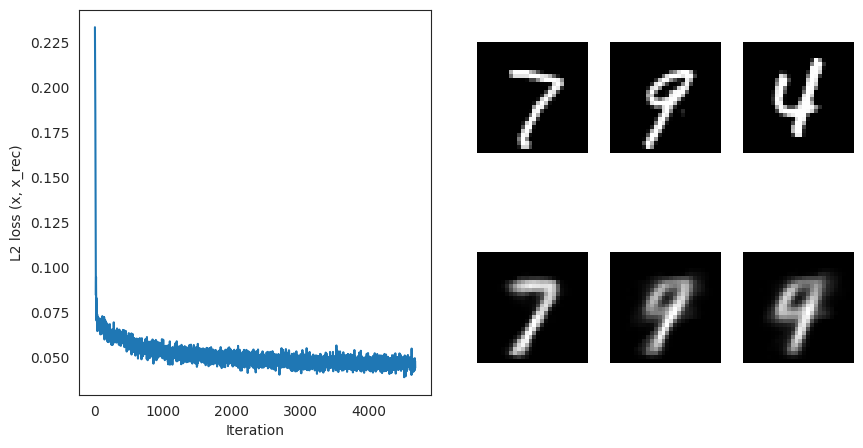

In [ ]:
train_vae(model, train_dataloader, optimizer)

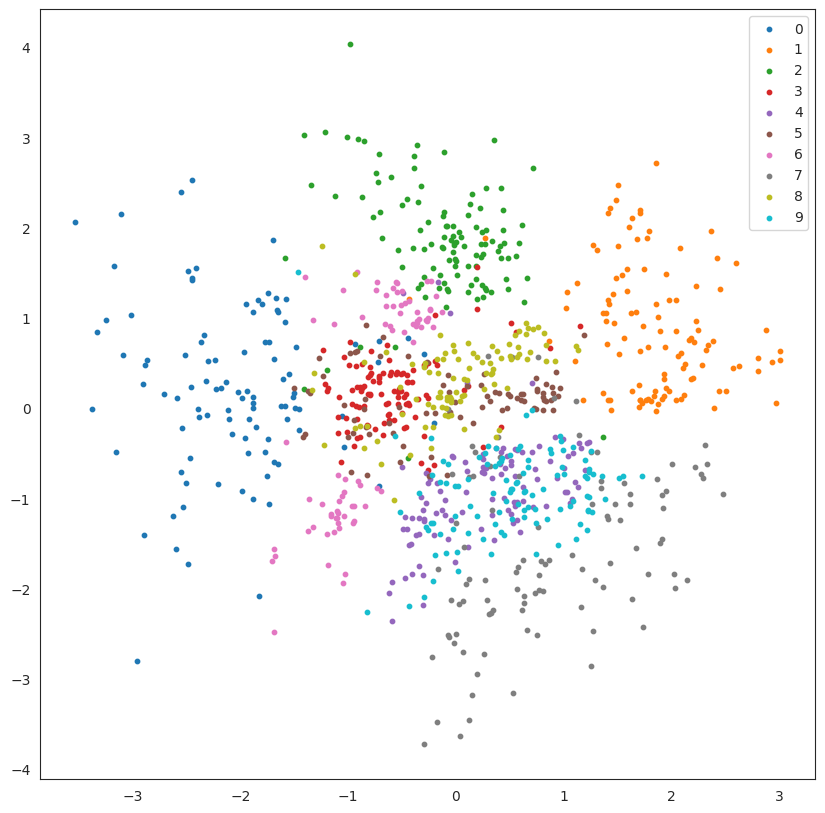

In [ ]:
# визуализируем получившееся латентное пр-во

lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model, 1000)

plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f"{cl}", s=10)

plt.legend()
plt.show()

Теперь обучим модель с латентным кодом длины 2 и обучаемым прайором на нормпотоках и визуализируем латентный код.

In [ ]:
model = VariationalAutoEncoder(2, prior="nf")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

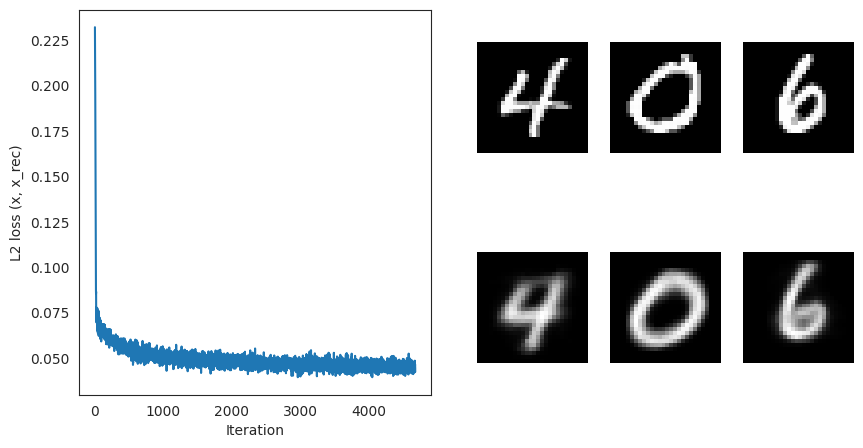

In [ ]:
train_vae(model, train_dataloader, optimizer)

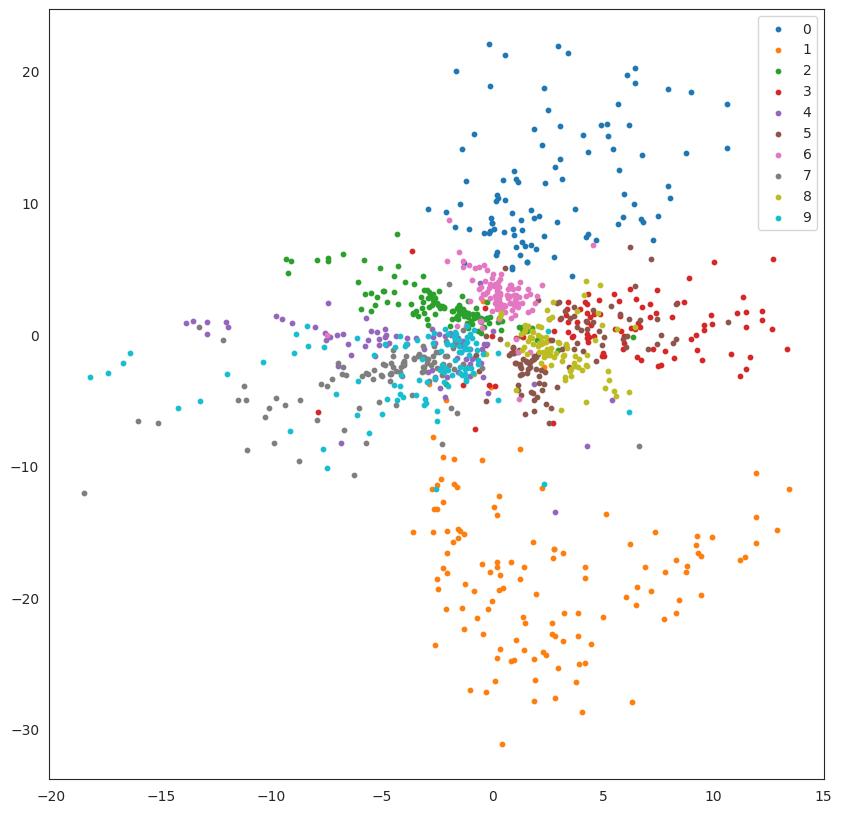

In [ ]:
# визуализируем получившееся латентное пр-во

lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model, 1000)

plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f"{cl}", s=10)

plt.legend()
plt.show()

Латентное пространство теперь не ограничено рамками нормального распределения и может обучаться как ему удобно. Благодаря этому классы становятся лучше разделимыми даже в 2d случае.